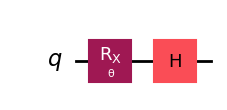

In [3]:
import numpy as np

from gate_level.spillover_noise_use_case.generic_spillover.spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.transpiler import PassManager

θ = Parameter('θ')
qc = QuantumCircuit(1)
qc.rx(θ, 0)
qc.h(0)

qc.draw('mpl')

In [4]:
θ_val = np.pi

In [5]:
from qiskit_aer.noise import NoiseModel,coherent_unitary_error
from qiskit.circuit.library import RXGate
γ = 0.1
noisy_unitary = RXGate(γ*θ_val).to_matrix()
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(coherent_unitary_error(noisy_unitary), 'rx', [0])

In [7]:
from qiskit_aer import AerSimulator
backend = AerSimulator(noise_model=noise_model)